***IMPORTS***

In [80]:
import csv
import os
import cv2
import copy
import random
import itertools

import pandas as pd
import numpy as np
import tensorflow as tf
import mediapipe as mp
from sklearn.model_selection import train_test_split
from utils import *

import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm

RANDOM_SEED = 42

In [81]:
from dataset.builder import *
from model.buider import *

In [136]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [93]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

***encoder+decoder***

In [115]:
decoder_classess = np.load('./data/encodeers/decode_final.npy', allow_pickle=True)

In [116]:
label_encoder = LabelEncoder()

In [117]:
label_encoder.classes_ = decoder_classess

In [129]:
decoder_classess

array(['Жарить', 'З', 'Золото', 'Л', 'Лицо', 'Н', 'Привет!', 'Религия',
       'Ц', 'Ы', 'Ю', 'аккуратный', 'активный', 'амбициозный', 'банкет',
       'бежевый', 'без', 'беспокойство', 'благополучие', 'близко',
       'важный', 'ваш', 'вверх', 'вдохновлять', 'верблюд', 'вечер',
       'вечность', 'взять', 'вилка', 'вина', 'вкус', 'воздух',
       'встретить', 'вторник', 'глаз', 'глупый', 'ежик', 'жевать',
       'испуг', 'курица', 'лось', 'мальчик', 'мудрый', 'мышь', 'ночь',
       'овца', 'официант', 'панда', 'петух', 'собака', 'тебе'],
      dtype=object)

***MODEL***

In [87]:
# Example of model in model.model.py
# accessed by build_model from model.builder.py

class SLDence(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SLDence, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        #x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [122]:
input_size = 65 * 2 # 84
num_classes = 51
model = SLDence(input_size, num_classes)
num_epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [123]:
model.load_state_dict(torch.load('./model/last_run/model_20.pth'))
model.to('cuda')

LandmarkFCN(
  (fc1): Linear(in_features=130, out_features=256, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=51, bias=True)
)

***MEDIAPIPE***

In [124]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5, static_image_mode=True)

I0000 00:00:1715629829.291950   23423 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1715629829.292883   76127 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.2-manjaro1.1), renderer: Mesa Intel(R) UHD Graphics 630 (CFL GT2)


In [91]:
# Predicting landmarks and drawing 
def detect_landmarks(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(frame_rgb)
    
    
    
    
    # Right hand
    mp_drawing.draw_landmarks(frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )

    # Left Hand
    mp_drawing.draw_landmarks(frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )

    # Pose Detections
    mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )
    
    


    return frame, results


In [92]:
# Normalization and preprocessing done in dataset
def transform(results):
    
    left_hand_pos = results.left_hand_landmarks
    right_hand_pos = results.right_hand_landmarks
    body_pos = results.pose_landmarks
    
    fill_value = 0.
    
    num_hand_landmarks = 21
    num_body_landmarks = 23
    num_dimensions = 2
    
    image_width, image_height = 512, 512
    landmark_list = []
    
    # Getting body keypoints:
    if body_pos is not None:
        body_pos = body_pos.landmark
        body_pos = np.array([[body_pos[indx].x, body_pos[indx].y] for indx in range(num_body_landmarks)])
    
    
    # Making landmarks in array of shape (21, 2) 
    if left_hand_pos is not None:
        left_hand_pos = np.array([[landmark.x, landmark.y] for landmark in left_hand_pos.landmark]) # ignore landmark z
    if right_hand_pos is not None:
        right_hand_pos = np.array([[landmark.x, landmark.y] for landmark in right_hand_pos.landmark]) # ignore landmark z
                  

    # Creating with filled "fill_value" array for placing landmarks in
    concatenated_pos = np.full(((num_hand_landmarks * 2) + num_body_landmarks, num_dimensions), fill_value)
    
    if left_hand_pos is not None:
        concatenated_pos[:num_hand_landmarks] = left_hand_pos

    if right_hand_pos is not None:
        concatenated_pos[num_hand_landmarks:(num_hand_landmarks*2)] = right_hand_pos
        
    concatenated_pos[(num_hand_landmarks*2):] = body_pos
    
    concatinated_1d = []
    if body_pos is None:
        base_x, base_y = concatenated_pos[0]
    else:
        base_x, base_y = body_pos[11]
    for index, landmark_point in enumerate(concatenated_pos):
        if landmark_point[0] == 0 and landmark_point[1] == 0:
            concatinated_1d.append(0.0)
            concatinated_1d.append(0.0)
            continue

        concatinated_1d.append(concatenated_pos[index][0] - base_x + 0.1)
        concatinated_1d.append(concatenated_pos[index][1] - base_y + 0.1)

    # Normalization
    max_value = max(concatinated_1d)
    
    
    def normalize_(n):
        if max_value ==0:
            return 0
        return n / max_value

    concatinated_1d = list(map(normalize_, concatinated_1d))
    
    return torch.tensor(concatinated_1d, dtype=torch.float32)

In [135]:
# Real Time excecution
cap = cv2.VideoCapture(0)

    
while cap.isOpened():
    ret, frame = cap.read()

    image = cv2.resize(frame, (512, 512))
    # Make Detections
    image, result = detect_landmarks(image)

    input_data = transform(result).view(-1, 65*2).cuda() 
    with torch.no_grad():
        output = model(input_data)

    if torch.max(output) > 0.8:
        
        prediction = output.argmax(dim=1).item()
        if previous != prediction:
            previous = prediction
        out_text = label_encoder.inverse_transform([previous])[0]
    else:
        out_text = ' '
    cv2.putText(image, out_text, (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)


    cv2.imshow('Raw Webcam Feed', image)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[ WARN:0@32417.034] global cap_v4l.cpp:997 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@32417.035] global obsensor_uvc_stream_channel.cpp:159 getStreamChannelGroup Camera index out of range


In [98]:
#REAL time demo
model.eval()
cap = cv2.VideoCapture(0)
previous = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.resize(frame, (512, 512))
    frame = cv2.flip(frame, 1)
    # Detect hand landmarks in the frame
    frame, result = detect_landmarks(frame)
    input_data = transform(result).view(-1, 65*2).cuda() # 84*2/ 
    with torch.no_grad():
        output = model(input_data)

    if torch.max(output) > 0.8:
        # Get the index of the class with the highest probability
        prediction = output.argmax(dim=1).item()  # Assuming output is a tensor of class probabilities
        if previous != prediction:
            previous = prediction
        out_text = label_encoder.inverse_transform([previous])[0]
    else:
        out_text = ' '
    cv2.putText(frame, out_text, (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the processed frame
    cv2.imshow('Hand Landmark Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


I0000 00:00:1715628336.958683   23423 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1715628336.974661   75355 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.2-manjaro1.1), renderer: Mesa Intel(R) UHD Graphics 630 (CFL GT2)


***Data***

In [94]:
# It is example of dataset, located in dataset/handLandmarks.py and used in builder.py 
# in def build_dataset()

def build_dataset(annotation, train = False):
    dataset = HandLandmarksDataset(annotation = annotation, train=train)
    return dataset

def build_dataloader(dataset, batch_size=32):
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    return dataloader

def check_dataset(dataset):
    # Check if all train images in dataset can be detected with mediapipe:
    # input: dataset
    # output: nothing, show image that did not pass and it path
    for i in tqdm(range(len(dataset))):
        a = dataset[i]
        pass

    
class HandLandmarksDataset(Dataset):
    def __init__(self, annotation, train = False, num_classes = 51):
        self.holistic = mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5, static_image_mode=True)
        self.train = train
        self.annotation = pd.read_csv(annotation)
        self.num_classes = num_classes
        self.image_paths = self.annotation['attachment_id'].values
        self.labels = self.annotation['text'].values
        self.to_delete = []
        
    def __len__(self):
        return len(self.image_paths)
    
    
    
    def concatinate_features(self, left_hand_pos, right_hand_pos, body_pos):
        num_hand_landmarks = 21 
        num_body_landmarks = 23
        num_dimensions = 2 
        fill_value=0.

        concatenated_pos = np.full(((num_hand_landmarks * 2) + num_body_landmarks, num_dimensions), fill_value)
    
        if left_hand_pos is not None:
            concatenated_pos[:num_hand_landmarks] = left_hand_pos
        if right_hand_pos is not None:
            concatenated_pos[num_hand_landmarks:(num_hand_landmarks*2)] = right_hand_pos
        concatenated_pos[(num_hand_landmarks*2):] = body_pos

        return concatenated_pos

    
    def pre_process_landmarks(self, concatenated_pos, body_pos):
        concatinated_1d = []
        if body_pos is None:
            base_x, base_y = concatenated_pos[0]
        else: 
            base_x, base_y = body_pos[11]
        for index, landmark_point in enumerate(concatenated_pos):
            if landmark_point[0] == 0 and landmark_point[1] == 0:
                concatinated_1d.append(0.0)
                concatinated_1d.append(0.0)
                continue

            concatinated_1d.append(concatenated_pos[index][0] - base_x + 0.1)
            concatinated_1d.append(concatenated_pos[index][1] - base_y + 0.1)

        # Normalization
        max_value = max(concatinated_1d)


        def normalize_(n):
            if max_value ==0:
                return 0
            return n / max_value

        concatinated_1d = list(map(normalize_, concatinated_1d))

        return torch.tensor(concatinated_1d, dtype=torch.float32)
    

    def extract_landmarks(self, results):
        left_hand_pos = results.left_hand_landmarks
        right_hand_pos = results.right_hand_landmarks
        body_pos = results.pose_landmarks
        num_body_landmarks = 23

        # Getting body keypoints:
        if body_pos is not None:
            body_pos = body_pos.landmark
            body_pos = np.array([[body_pos[indx].x, body_pos[indx].y] for indx in range(num_body_landmarks)])


        # Making landmarks in array of shape (21, 2) 
        if left_hand_pos is not None:
            left_hand_pos = np.array([[landmark.x, landmark.y] for landmark in left_hand_pos.landmark]) # ignore landmark z
        if right_hand_pos is not None:
            right_hand_pos = np.array([[landmark.x, landmark.y] for landmark in right_hand_pos.landmark]) # ignore landmark z



        return left_hand_pos, right_hand_pos, body_pos

    
    def random_flip(self, image):
        if np.random.choice([True, False]):
            return cv2.flip(image, 1)
        return image
    

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.train:
            image = self.random_flip(image)
        if image is None:
            raise IOError(f"Failed to read image: {image_path}")
            
        landmarks = self.holistic.process(image)
    
        # ERROR image detection
        if landmarks.pose_landmarks is None: 
            print(image_path)
            self.to_delete.append(image_path)
            
        left_hand_features, right_hand_features, body_features = self.extract_landmarks(landmarks)
        features = self.concatinate_features(left_hand_features, right_hand_features, body_features)
        features = self.pre_process_landmarks(features, body_features)
        
        return torch.tensor(features, dtype=torch.float32), label

In [95]:
dataset = build_dataset(annotation='./data/annotations/train_final_equaly_distributed.csv', train=True)

I0000 00:00:1715618614.005899   23423 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1715618614.007137   68785 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.2-manjaro1.1), renderer: Mesa Intel(R) UHD Graphics 630 (CFL GT2)


In [96]:
# Train test(val) seperation
train_ratio = 0.8

num_samples = len(dataset)
num_train_samples = int(train_ratio * num_samples)
num_test_samples = num_samples - num_train_samples

train_dataset, test_dataset = random_split(dataset, [num_train_samples, num_test_samples])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

***Training + Validating***

In [97]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for batch in train_dataloader:
        landmarks, labels = batch  # Assuming batch contains landmarks tensor and corresponding labels
        landmarks = landmarks.view(-1, input_size)  # Flatten the landmarks tensor if necessary
        
        landmarks, labels = landmarks.to('cuda'), labels.to('cuda')
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(landmarks)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    if (epoch+1)%5==0:
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_batch in test_dataloader:
                val_landmarks, val_labels = val_batch  # Assuming batch contains landmarks tensor and corresponding labels
                val_landmarks = val_landmarks.view(-1, input_size)  # Flatten the landmarks tensor if necessary

                val_landmarks, val_labels = val_landmarks.to('cuda'), val_labels.to('cuda')

                # Forward pass
                val_outputs = model(val_landmarks)
                val_loss = criterion(val_outputs, val_labels)

                # Update validation statistics
                val_running_loss += val_loss.item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        # Calculate validation loss and accuracy
        val_loss = val_running_loss / len(test_dataloader)
        val_accuracy = 100 * val_correct / val_total
        print(f"Vall Loss: {val_loss:.3f}, Accuracy: {val_accuracy:.2f}%")
        torch.save(model.state_dict(), f'model/last_run/model_{epoch+1}.pth')


    print(f"Epoch {epoch+1}, Loss: {(running_loss / len(train_dataloader)):.3f}, Accuracy: {(100 * correct / total):.2f}%")
    scheduler.step()
    
    
print("Training finished!")


/home/emasle/code/SignLanguageMediapipe/data/train_frames/3cd6e89f-4672-417e-b897-29c30d603b05.mp4/0038.jpg
Epoch 1, Loss: 2.587, Accuracy: 24.27%
Epoch 2, Loss: 1.678, Accuracy: 47.20%
/home/emasle/code/SignLanguageMediapipe/data/train_frames/e139e577-84dc-4c25-a801-2482ae02d755.mp4/0042.jpg
Epoch 3, Loss: 1.335, Accuracy: 57.89%
/home/emasle/code/SignLanguageMediapipe/data/train_frames/3cd6e89f-4672-417e-b897-29c30d603b05.mp4/0038.jpg
Epoch 4, Loss: 1.131, Accuracy: 64.25%
/home/emasle/code/SignLanguageMediapipe/data/train_frames/3cd6e89f-4672-417e-b897-29c30d603b05.mp4/0038.jpg
/home/emasle/code/SignLanguageMediapipe/data/train_frames/7d9083d6-42fd-47ba-a3b8-88f7806fd2c3.mp4/0024.jpg
Vall Loss: 1.182, Accuracy: 71.04%
Epoch 5, Loss: 1.001, Accuracy: 68.81%
/home/emasle/code/SignLanguageMediapipe/data/train_frames/e139e577-84dc-4c25-a801-2482ae02d755.mp4/0042.jpg
Epoch 6, Loss: 0.887, Accuracy: 72.58%
/home/emasle/code/SignLanguageMediapipe/data/train_frames/e139e577-84dc-4c25-a801-2

In [18]:
#torch.save(model.state_dict(), 'model/checkpoints/model_final.pth')

In [131]:
true_labels_list = []
predicted_labels_list = []

model.eval()
for batch in tqdm(test_dataloader):
    landmarks, labels = batch  
    landmarks = landmarks.view(-1, input_size)
    landmarks = landmarks.to('cuda')
       
    
    with torch.no_grad():
        output = model(landmarks)
    
    true_labels_list.extend(labels.numpy())
    
    predicted_labels = torch.argmax(output, dim=1)
    predicted_labels_list.extend(predicted_labels.cpu().numpy())


true_labels_array = np.array(true_labels_list)
predicted_labels_array = np.array(predicted_labels_list)

 27%|████████████████                                           | 12/44 [00:27<01:13,  2.31s/it]

/home/emasle/code/SignLanguageMediapipe/data/train_frames/9e1073d1-5974-4150-8d22-25a297f26f32.mp4/0007.jpg


100%|███████████████████████████████████████████████████████████| 44/44 [01:40<00:00,  2.29s/it]


***EDA***

In [142]:
accuracy = accuracy_score(true_labels_array, predicted_labels_array)

precision = precision_score(true_labels_array, predicted_labels_array, average='weighted')

recall = recall_score(true_labels_array, predicted_labels_array, average='weighted')

f1 = f1_score(true_labels_array, predicted_labels_array, average='weighted')

# Print the results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Accuracy:  0.9066
Precision: 0.9124
Recall:    0.9066
F1 Score:  0.9072


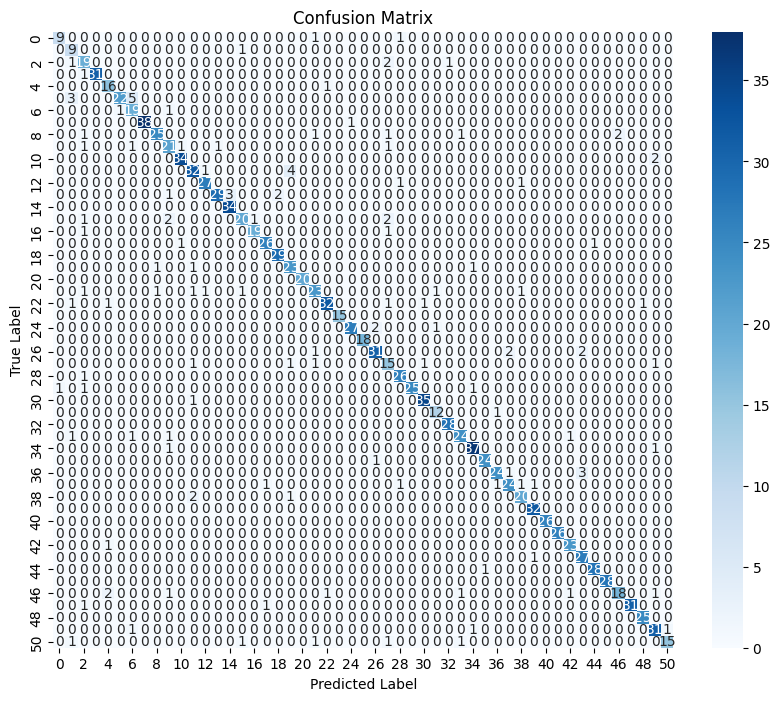

In [132]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels_array, predicted_labels_array)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [77]:
text_distribution = train_pd['text'].value_counts()

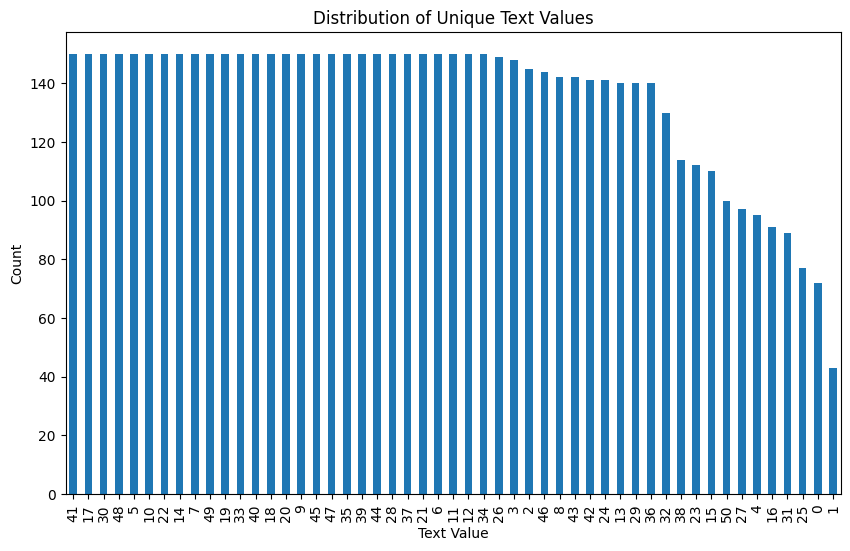

In [78]:
text_distribution.plot(kind='bar', figsize=(10, 6), title='Distribution of Unique Text Values')
plt.xlabel('Text Value')
plt.ylabel('Count')
plt.show()

***DATA MINING + DATA VISUALIZING***

In [79]:
train_pd.to_csv('./data/annotations/train_final_equaly_distributed.csv', index=False)

In [75]:
texts_over_limit = text_distribution[text_distribution > 150].index

# Limit the number of samples for texts with more than 150 samples to 150
for text in texts_over_limit:
    samples_to_keep = train_pd[train_pd['text'] == text].head(150)
    train_pd = train_pd.drop(train_pd[train_pd['text'] == text].index)
    train_pd = pd.concat([train_pd, samples_to_keep])

len(train_pd)

6902

In [33]:
# Checking on a video

folder_path = '/home/emasle/code/SignLanguageMediapipe/data/train_frames/0987f6df-f619-46ac-ae6d-ebcde2cff08b.mp4'

if not os.path.isdir(folder_path):
    print("Error: Folder does not exist.")
    exit()

image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.jpg')]

image_files.sort()

current_index = 0
previous = 0
while current_index < len(image_files):
  
    frame = cv2.imread(image_files[current_index])

    _, result = detect_landmarks(frame)
    
    input_data = transform(result).view(-1, 65*2).cuda()   
    with torch.no_grad():
        output = model(input_data)
         
    if torch.max(output) > 0.5:
        prediction = output.argmax(dim=1).item()  
        if previous != prediction:
            previous = prediction
    
    cv2.putText(frame, label_encoder.inverse_transform([previous])[0], (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)       
    # Display the processed frame with landmarks
    cv2.imshow('Hand Landmark Detection', frame)

    
    key = cv2.waitKey(0)
    if key & 0xFF == ord('q'):  # Exit if 'q' is pressed
        break
    elif key & 0xFF == ord('n'):  # Move to the next image if 'n' is pressed
        current_index += 1

cv2.destroyAllWindows()


In [12]:
# Mining data from a video

anot = pd.read_csv('./data/annotations/croped_anotation.csv')

anot = anot.sort_values(by = 'text')

anot['text'] = label_encoder.inverse_transform(anot['text'])

anot['word_count'] = anot['text'].str.split().apply(len)

# Drop rows where the number of words is greater than 1
anot = anot[anot['word_count'] <= 1]

# Drop the 'word_count' column (optional)
anot.drop(columns=['word_count'], inplace=True)

In [26]:
anot

,attachment_id,text,user_id,height,width,length,train
217,84561f3b-35d0-411f-9570-ab20bd0b5465,ежик,0211b488644476dd0fec656ccb9b74fc,1920,1080,62.0,True
3095,7e86f32c-73b3-4246-bf4d-07a604bc2138,ежик,e0ca58d03fc73a305046edcdf7ef7492,1080,1920,55.0,False
3026,d43fbc06-3fcf-4850-a70a-4d92e6d0d6ac,ежик,ca6b767f0cccf093ba737ae2fc4fec3d,1920,1080,43.0,False
91,e456fcd6-5bb3-4d97-a472-271e9c56e68b,ежик,db573f94204e56e0cf3fc2ea000e5bdc,1280,720,50.0,True
120,166b29f4-8bf2-4770-994a-278cdbf23c7c,ежик,0211b488644476dd0fec656ccb9b74fc,1920,1080,58.0,True
...,...,...,...,...,...,...,...
2050,b2f0f14e-c247-4e0e-9186-656589a498a4,тебе,db573f94204e56e0cf3fc2ea000e5bdc,1280,720,31.0,True
3613,4d6ab706-9076-4444-a3d7-bf9d1246888a,тебе,2e900e56b0b0d7fe1c3978e6391fbc91,1920,1080,40.0,False
1997,c4b9f411-fdb0-4efb-b69f-d4bca355faa8,тебе,0211b488644476dd0fec656ccb9b74fc,1920,1080,18.0,True
2135,6aeabf8c-860e-4da7-8e2c-5328ac174a01,тебе,185bd3a81d9d618518d10abebf0d17a8,1920,1080,42.0,True


In [29]:
stop = False
train_pd = pd.DataFrame(columns=['attachment_id', 'text'])
root = '/home/emasle/code/SignLanguageMediapipe/data/train_frames/'
previous_target = ''
for pth, target in anot[['attachment_id','text']].values:
    if target != previous_target:
        train_pd.to_csv('train_pd.csv', index=False)
        print(target)
        previous_target = target
    folder_path = os.path.join(root, (pth+'.mp4'))
    if not os.path.exists(folder_path):
        continue
    image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.jpg')]

    # Sort the image files
    image_files.sort()

    # Initialize a counter to keep track of the current image index
    current_index = 0
    if stop:
        break
    while current_index < len(image_files):

        frame = cv2.imread(image_files[current_index])
        frame = cv2.resize(frame, (512,512))
        frame, result = detect_landmarks(frame)

        # Display the processed frame with landmarks
        cv2.putText(frame, target, (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        cv2.imshow('Hand Landmark Detection', frame)

        # Check for key press to move to the next image or exit
        key = cv2.waitKey(0)
        if key & 0xFF == ord('y'):
            new_row = {'attachment_id': image_files[current_index], 'text': target}
            train_pd = train_pd._append(new_row, ignore_index=True)
            current_index += 1
        if key & 0xFF == ord('q'):  # Exit if 'q' is pressed
            stop = True
            break
        elif key & 0xFF == ord('n'):  # Move to the next image if 'n' is pressed
            current_index += 1
        elif key & 0xFF == ord('b'):  # Move to the one image back if 'b' is pressed
            if current_index > 0:
                current_index -= 1
        elif key & 0xFF == ord('m'):  # Move to the next 10 images if 'm' is pressed
            current_index += 10

    # Close all windows
    cv2.destroyAllWindows()


ежик
жевать
испуг
курица
лось
мальчик
мудрый
мышь
необходимый
ночь
овца
официант
ошеломить
панда
петух
собака
старый
тебе


***encoding from mining***

In [37]:
label_encoder = LabelEncoder()

In [38]:
train_pd['text'] = label_encoder.fit_transform(train_pd['text'])

In [40]:
np.save('decode_final.npy', label_encoder.classes_)

In [60]:
train_pd.to_csv('train_final_save.csv', index=False)

In [167]:
# decoding example
train_pd['text'] = label_encoder.inverse_transform(train_pd['text'])